In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # this increases width to full screen

In [2]:
import os
import numpy as np # import numerical python
import pandas as pd # import pandas
import scipy as sp
import xarray as xr # import xarray
import struct # import for importing binary
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
from scipy.special import erf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
from matplotlib import cm
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [185]:
A = 200
B = 50
data = np.zeros([A, B])

loc1 = 1
loc2 = 5
CPL = A/2

for i in np.arange(A):
    if i < CPL:
        data[i, :] = np.sort(np.random.exponential(scale=loc1, size=B))
    else:
        data[i, :] = np.sort(np.random.exponential(scale=loc2, size=B))

In [186]:
def loc_gen_dist(m, i, j):
    # loc_gen_dist function
    # locations of where distances are stored from the scipy.spatial.distance metric
    # scipy.spatial.distance computes on An m by n array of m original observations in an n-dimensional space.
    # The metric dist(u=X[i], v=X[j]) is computed and stored in entry m * i + j - ((i + 2) * (i + 1)) // 2.
    # where i < j < m
    # ================INPUTS============= 
    # m is the length of the matrix of n-dimensional observations (i.e. an integer)
    # i are the timesteps you wish to find the distances of between specified other locations
    # j are the other locations
    # ================OUTPUT============= 
    # loc, these locations
    if (not isinstance(i, int)) & (not isinstance(j, int)): # if we cannot simply do the computation for one or a few locations
        if len(i) < len(j): # if fewer is than js, it is faster to do the calculation for each i
            for k in i: # for each i value
                if k == i[0]: # if it's the first i value
                    j_locs = j[j > k] # remove any above j
                    loc = m * k + j_locs - ((k + 2) * (k + 1)) // 2 # one i, many js
                else:
                    j_locs = j[j > k] # remove any above j
                    loc_temp = m * k + j_locs - ((k + 2) * (k + 1)) // 2 # one i, many js
                    loc = np.hstack([loc, loc_temp]) # concatenate arrays
        else:
            for k in j: # for each j value
                if k == j[0]: # if it's the first j value
                    i_locs = i[i < k] # remove any above j
                    loc = m * i_locs + k - ((i_locs + 2) * (i_locs + 1)) // 2 # one j, many is
                else:
                    i_locs = i[i < k] # remove any above j
                    loc_temp = m * i_locs + k - ((i_locs + 2) * (i_locs + 1)) // 2 # one j, many is
                    loc = np.hstack([loc, loc_temp]) # concatenate arrays
    else:
        loc = m * i + j - ((i + 2) * (i + 1)) // 2 # if one of i and j is one number, this simple calculation is fine
    loc = np.unique(loc) # make sure no duplicates
    return loc

In [187]:
def EmpiricalDivergence(data, t, alpha):
    # EmpiricalDivergence function
    # outputs empirical divergence metric (Equations 5 & 6 from Matteson, D. S.; James, N. A. A. J. Am. Stat. Assoc. 2014, 109 (505), 334–345. https://doi.org/10.1080/01621459.2013.849605.)
    # ================INPUTS============= 
    # data is data matrix (should be n by m)
    # t is timestep (or timesteps) to measure divergence between <t section and >=t section
    # alpha is power order
    # ================OUTPUT============= 
    # Q, scaled empirical divergence function
    try:
        test0 = isinstance(t, int)
        if test0 == True:
            tlen = 1
        else:
            tlen = len(t)
        test1 = np.where(t == 0)[0]
        if len(test1) > 0:
            raise Exception('t cannot contain zeros')
        test2 = np.min(t)
        if np.min(t) == 1:
            raise Exception('lowest value of t should be > 1')
        test3 = np.max(t)
        if np.max(t) == len(data)-1:
            raise Exception('highest value of t should be < len(data)-1')
    except Exception as error:
        print('Caught this error: ' + repr(error))
        return
    distances = np.power(sp.spatial.distance.pdist(data, 'euclidean'), alpha) # get all distances that will be used for the divergence measurement
    ij = np.arange(len(data)) # get ij
    bcsn = np.reciprocal(sp.special.binom(t, 2)) # get binomial coefficients for n
    bcsm = np.reciprocal(sp.special.binom(np.subtract(len(data), t), 2)) # get binomial coefficients for m
    varepsilon = np.zeros(tlen) # make array to fill
    term1 = np.zeros(tlen) # make array to fill
    term2 = np.zeros(tlen) # make array to fill
    term3 = np.zeros(tlen) # make array to fill
    ns = t # get ns
    ms = np.subtract(len(data), t) # get ms
    prefactor = np.divide(2., np.multiply(ns,ms)) # get prefactor for term 1
    prefactor_q = np.divide(np.multiply(ms, ns), np.add(ms, ns)) # get prefactor for overall divergence measure
    if test0 == True:
        i = ij[:t] # generate i
        j = ij[t:] # generate j
        locs1 = loc_gen_dist(len(data), i, j) # get locations of distances for term 1
        term1[0] = np.sum(distances[locs1]) # term 1 of divergence equation
        locs2 = loc_gen_dist(len(data), i, i) # get locations of distances for term 2
        term2[0] = np.sum(distances[locs2]) # term 2 of divergence equation
        locs3 = loc_gen_dist(len(data), j, j) # get locations of distances for term 3
        term3[0] = np.sum(distances[locs3]) # term 3 of divergence equation
    else:
        for indval in np.arange(len(t)):
            i = ij[:t[indval]] # generate i
            j = ij[t[indval]:] # generate j
            locs1 = loc_gen_dist(len(data), i, j) # get locations of distances for term 1
            term1[indval] = np.sum(distances[locs1]) # term 1 of divergence equation
            locs2 = loc_gen_dist(len(data), i, i) # get locations of distances for term 2
            term2[indval] = np.sum(distances[locs2]) # term 2 of divergence equation
            locs3 = loc_gen_dist(len(data), j, j) # get locations of distances for term 3
            term3[indval] = np.sum(distances[locs3]) # term 3 of divergence equation
    term1 = np.multiply(prefactor, term1) # hit term1 with prefactor
    term2 = np.multiply(bcsn, term2) # hit term2 with binomials
    term3 = np.multiply(bcsm, term3) # hit term3 with binomials
    Q = np.multiply(prefactor_q, np.subtract(np.subtract(term1, term2), term3)) # generate Q
    return Q

In [188]:
alpha = 1
t = np.arange(2, len(data)-2)
Q = EmpiricalDivergence(data, t, alpha)

In [189]:
%timeit EmpiricalDivergence(data, t, alpha)

419 ms ± 5.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


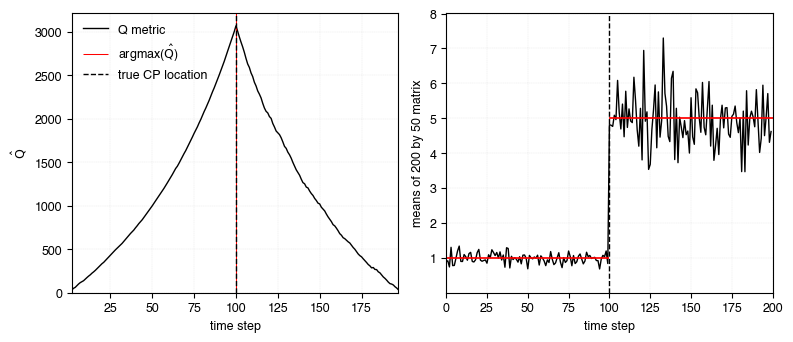

In [190]:
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['font.size'] = 9


fig, axs= plt.subplots(1, 2)
lwg=0.25
axs[0].plot(t, Q, color='k', lw=1, label='Q metric')
axs[0].vlines(t[np.argmax(Q)], 0, np.nanmax(Q)*2, lw=0.75, color='r', label=r'argmax($\hat{\mathsf{Q}}$)')
axs[0].vlines(CPL, 0, np.nanmax(Q)*2, lw=1, ls='--', color='k', label='true CP location')
axs[0].legend(loc='upper left', frameon=False)
axs[0].set_xlabel('time step')
axs[0].set_ylabel(r'$\hat{\mathsf{Q}}$')
axs[0].set_xlim([np.nanmin(t), np.nanmax(t)])
axs[0].set_ylim([0, np.nanmax(Q)+(0.05*np.nanmax(Q))])
axs[0].grid(True,which="both",ls="--",c='gray', lw=lwg, alpha=0.25)  

axs[1].plot(np.arange(0, len(data)), np.mean(data, axis=1), color='k', lw=1)
axs[1].vlines(CPL, 0, np.nanmax(Q)*2, lw=1, ls='--', color='k', label='true CP location')
axs[1].hlines(loc1, xmin=0, xmax=len(data)/2, color='r', lw=1.25)
axs[1].hlines(loc2, xmin=len(data)/2, xmax=len(data), color='r', lw=1.25)

axs[1].set_xlabel('time step')
axs[1].set_ylabel(r'means of '+str(A)+' by '+str(B)+' matrix')
axs[1].set_xlim([0, len(data)])
axs[1].set_ylim([np.min(data), np.max(np.mean(data, axis=1))*1.1])
axs[1].grid(True,which="both",ls="--",c='gray', lw=lwg, alpha=0.25)
plt.tight_layout()

In [191]:
def SignificanceTester(data, alpha, tau_k, Q_k, R, pval=0.05):
    # SignificanceTester function
    # permutaive check of significance (Section 2.4 of Matteson, D. S.; James, N. A. A. J. Am. Stat. Assoc. 2014, 109 (505), 334–345. https://doi.org/10.1080/01621459.2013.849605.)
    # ================INPUTS============= 
    # data is data matrix (should be n by m)
    # alpha is power order
    # tau_k is timestep to measure divergence between <tau_k section and >=tau_k section
    # Q_k is Q value at that timestep from non-permuted data
    # R is number of permutations
    # pval is significance threshold, default 0.05
    # ================OUTPUT============= 
    # sig is boolean that determines if change-point is significant
    # p_test is p value output by permutation test
    tests = np.zeros(R) # initialise test matrix
    arr = np.zeros([R, len(data)]) + np.arange(len(data)) # generate array of locations
    permuted = np.array(arr[np.arange(len(arr))[:,None], np.random.randn(*arr.shape).argsort(axis=1)], dtype=int) # permute locations
    for i in np.arange(R): # for every permutation of the data
        data_p = data[permuted[i, :], :] # get permuted data
        Q_p = EmpiricalDivergence(data_p, tau_k, alpha) # test Q at tau_k location
        tests[i] = Q_p # put Q_p into test matrix
    p_test = np.divide(len(tests[tests > Q[tau_k]]), np.add(R, 1.)) # generate p value
    sig = np.multiply(p_test < pval, 1) # generate significance test
    return sig, p_test

In [192]:
tau_k = int(len(data)/2)
Q_k = np.nanmax(Q)
R = 499
alpha = 1
sig, p_test =  SignificanceTester(data, alpha, tau_k, Q_k, R)

In [193]:
%timeit SignificanceTester(data, alpha, tau_k, Q_k, R)

1.46 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


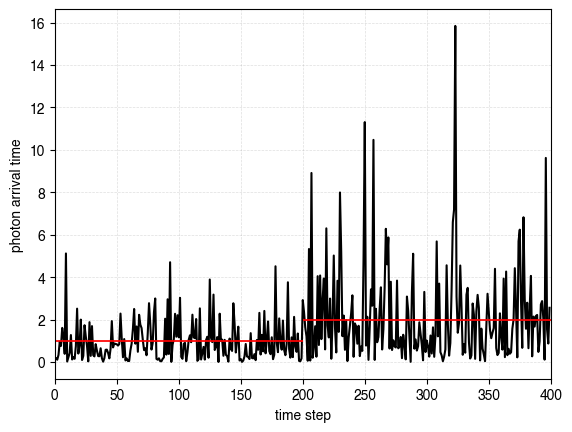

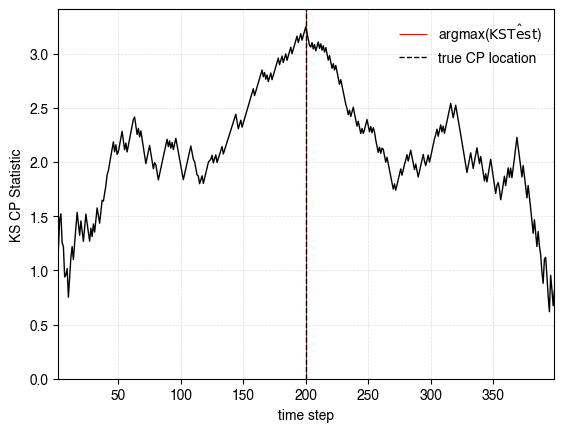

0.0 % error


In [28]:
A = 400
data = np.zeros([A])

loc1 = 1
loc2 = 2
CPL = A/2

for i in np.arange(A):
    if i < CPL:
        data[i] = np.random.exponential(loc1, size=1)
    else:
        data[i] = np.random.exponential(loc2, size=1)

plt.plot(np.arange(0, len(data)), data, color='k')
plt.hlines(loc1, xmin=0, xmax=CPL, color='r', lw=1.25)
plt.hlines(loc2, xmin=CPL, xmax=len(data), color='r', lw=1.25)

plt.xlim([0, A])
plt.ylabel('photon arrival time')
plt.xlabel('time step')
plt.grid(True,which="both",ls="--",c='gray', lw=0.5, alpha=0.25)  
plt.show(block=False)
ksvals = np.zeros([A-2])
for i in np.arange(A-2):
    rvs = data[:i+2]
    cdf = data[i+2:]
    prefactor = np.sqrt((len(rvs)*len(cdf))/len(data))
    ksvals[i] = prefactor*sp.stats.kstest(rvs, cdf, method='exact').statistic

t = np.arange(2, len(data))

plt.plot(t, ksvals, lw=1, color='k')
plt.ylabel('KS CP Statistic')
plt.xlabel('time step')
plt.ylim([0, np.nanmax(ksvals)+(0.05*np.nanmax(ksvals))])
plt.xlim([np.min(t), np.max(t)])
plt.vlines(t[np.argmax(ksvals)], 0, np.nanmax(ksvals)*2, lw=0.75, color='r', label=r'argmax($\hat{\mathsf{KSTest}}$)')
plt.vlines(CPL, 0, np.nanmax(ksvals)*2, lw=1, ls='--', color='k', label='true CP location')
plt.legend(loc='best', frameon=False)

plt.grid(True,which="both",ls="--",c='gray', lw=0.5, alpha=0.25)  

plt.show(block=False)
print(str(np.around(100*(np.abs((len(data)/2)-(np.argmax(ksvals)+2))/(len(data)/2)), 2))+' % error')

In [9]:
from scipy.special import rel_entr

In [120]:
def bhattacharyya_distance(x, distribution1, distribution2):
    """ Estimate Bhattacharyya Distance (between General Distributions)
    
    Args:
        distribution1: a sample distribution 1
        distribution2: a sample distribution 2
    
    Returns:
        Bhattacharyya distance
    """
    DB = np.trapz(np.sqrt(distribution1*distribution2), x=x)
    BD = -np.log(DB)
    if BD < 0:
        BD = 0
    return BD

In [5]:
def exppdf(x, lambda_val):
     # exp function
     # outputs normalised exp lambda*exp(-lambda*x)
     # ================INPUTS============= 
     # x ix data points to evaluate pdf
     # lambda_val is exponential rate parameter
     # ================OUTPUT============= 
     # pdf, simulated signal
    pdf = np.multiply(lambda_val, np.exp(np.multiply(-lambda_val, x))) # make exponential pdf
    return pdf # return the exponential pdf

In [6]:
def gauss(x, sigma, mu):
     # gauss function
     # outputs normalised gaussian (1/(sqrt(2*pi)*sigma))*(exp(-0.5*((x-mu)^2 / sigma^2)))
     # ================INPUTS============= 
     # x ix data points to evaluate pdf
     # sigma is sigma of gaussian
     # mu is centre of gaussian
     # ================OUTPUT============= 
     # pdf, simulated signal
    prefactor = np.divide(1., np.multiply(sigma, np.sqrt(np.multiply(2., np.pi)))) # get normalisation prefactor
    expterm = np.exp(np.multiply(-0.5, np.divide(np.square(np.subtract(x, mu)), np.square(sigma)))) # get exponential term
    pdf = np.multiply(prefactor, expterm) # make gaussian pdf
    return pdf # return the gaussian pdf

In [7]:
def expgauss(x, tau, sigma):
    # expgauss function
    # outputs normalised sum-of-exponentials convolved with gaussians 
    # ================INPUTS============= 
    # x ix data points to evaluate pdf
    # tau is one lifetime
    # sigma is sigma of gaussian to convolve with exponential
    # ================OUTPUT============= 
    # simulated signal
    ksm = np.tile(np.divide(1., tau), (1, 1))  # make matrix of ks
    erfterm = 1. + erf(np.divide(np.subtract(x, np.multiply(ksm.T, np.square(sigma))), np.sqrt(2)*sigma))
    gaussterm = np.exp(np.divide(np.multiply(np.square(ksm.T), np.square(sigma)), 2.))
    return np.nansum(np.multiply(np.divide(np.multiply(1., ksm), 2.).T, np.multiply(np.multiply(np.exp(np.multiply(-ksm.T, x)), gaussterm), erfterm)), axis=0)

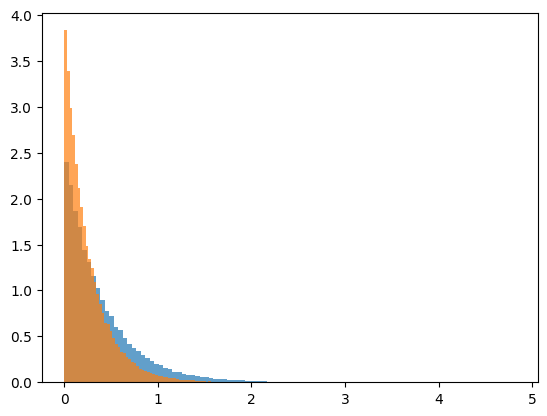

In [239]:
e_duration1 = np.random.exponential(scale=0.39, size=100000) # 0.39 and 0.25 are lifetime blinking time constants
e_duration2 = np.random.exponential(scale=0.25, size=100000)
plt.hist(e_duration1, 100, alpha=0.7, density=True); plt.hist(e_duration2, 100, alpha=0.7, density=True); plt.show(block=False)

0.06368623159989148


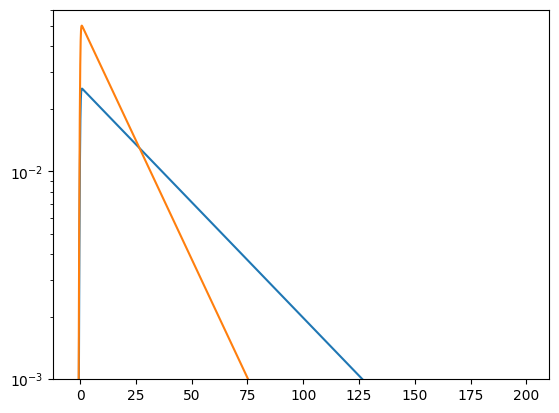

In [253]:
x = np.linspace(-2, 200, 1000000);
P = expgauss(x, 39, 0.3)
Q = expgauss(x, 19, 0.3)
plt.plot(x, P)
plt.plot(x, Q)
plt.yscale('log')
plt.ylim([1e-3, 0.06])
print(bhattacharyya_distance(x, P, Q))

In [201]:
BDists = np.zeros(100)

x = np.logspace(np.log10(1e-3), np.log10(100), 100000);
for i in enumerate(np.arange(2, 102)):
    Q = exppdf(x, 1./i[1])
    BDists[i[0]] = bhattacharyya_distance(x, P, Q)


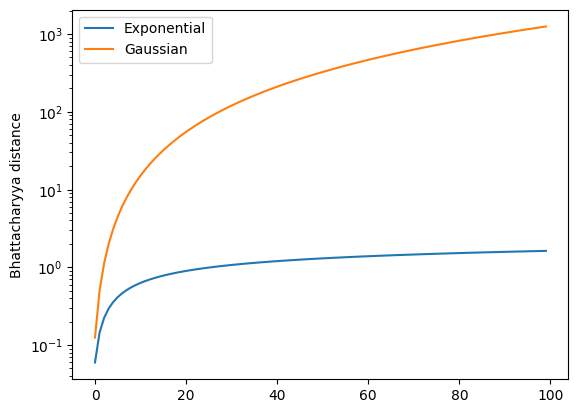

In [202]:
plt.plot(BDists, label='Exponential')
plt.plot(BDists_Gauss, label='Gaussian')
plt.ylabel('Bhattacharyya distance')
plt.yscale('log')
plt.legend(loc='best')
plt.show(block=False)

0.12499999999999994


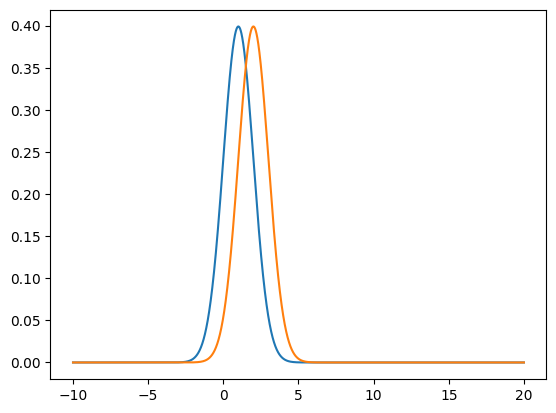

In [268]:
x2 = np.linspace(-10, 20, 100000)
P2 = gauss(x2, 1, 1)
Q2 = gauss(x2, 1, 2)
plt.plot(x2, P2)
plt.plot(x2, Q2)

BD = bhattacharyya_distance(x2, P2, Q2)
print(BD)

0.125

In [189]:
BDists_Gauss = np.zeros(100)

for i in enumerate(np.arange(1, 101)):
    BDists_Gauss[i[0]] = 0.25*(((0-i[1])**2)/(1**2 + 1**2)) + 0.5*np.log((1**2 + 1**2)/(2*1*1))


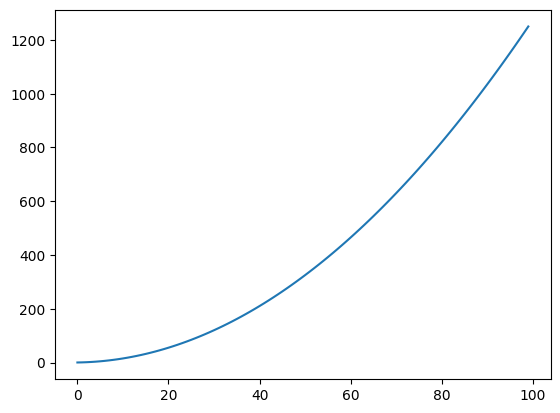